# Handwritten digit generation using GANs

In [2]:
!pip install -q torch_snippets
from torch_snippets import *
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision.utils import make_grid

In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

data_loader = torch.utils.data.DataLoader(MNIST('~/Data/mnist', train=True, download=True, transform=transform),batch_size=128, shuffle=True, drop_last=True)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( 
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.model(x)

In [5]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,784))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 1024]                803,840
|    └─LeakyReLU: 2-2                    [-1, 1024]                --
|    └─Dropout: 2-3                      [-1, 1024]                --
|    └─Linear: 2-4                       [-1, 512]                 524,800
|    └─LeakyReLU: 2-5                    [-1, 512]                 --
|    └─Dropout: 2-6                      [-1, 512]                 --
|    └─Linear: 2-7                       [-1, 256]                 131,328
|    └─LeakyReLU: 2-8                    [-1, 256]                 --
|    └─Dropout: 2-9                      [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 1]                   257
|    └─Sigmoid: 2-11                     [-1, 1]                   --
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable par

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 1024]                803,840
|    └─LeakyReLU: 2-2                    [-1, 1024]                --
|    └─Dropout: 2-3                      [-1, 1024]                --
|    └─Linear: 2-4                       [-1, 512]                 524,800
|    └─LeakyReLU: 2-5                    [-1, 512]                 --
|    └─Dropout: 2-6                      [-1, 512]                 --
|    └─Linear: 2-7                       [-1, 256]                 131,328
|    └─LeakyReLU: 2-8                    [-1, 256]                 --
|    └─Dropout: 2-9                      [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 1]                   257
|    └─Sigmoid: 2-11                     [-1, 1]                   --
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable par

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x): return self.model(x)

In [7]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 784]                 --
|    └─Linear: 2-1                       [-1, 256]                 25,856
|    └─LeakyReLU: 2-2                    [-1, 256]                 --
|    └─Linear: 2-3                       [-1, 512]                 131,584
|    └─LeakyReLU: 2-4                    [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 1024]                525,312
|    └─LeakyReLU: 2-6                    [-1, 1024]                --
|    └─Linear: 2-7                       [-1, 784]                 803,600
|    └─Tanh: 2-8                         [-1, 784]                 --
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
Total mult-adds (M): 2.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.67
Estimated Total Size (MB): 5.69


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 784]                 --
|    └─Linear: 2-1                       [-1, 256]                 25,856
|    └─LeakyReLU: 2-2                    [-1, 256]                 --
|    └─Linear: 2-3                       [-1, 512]                 131,584
|    └─LeakyReLU: 2-4                    [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 1024]                525,312
|    └─LeakyReLU: 2-6                    [-1, 1024]                --
|    └─Linear: 2-7                       [-1, 784]                 803,600
|    └─Tanh: 2-8                         [-1, 784]                 --
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
Total mult-adds (M): 2.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.67
Estimated Total Size (MB): 5.69

In [8]:
def noise(size):
    n = torch.randn(size, 100)
    return n.to(device)

In [9]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, torch.ones(len(real_data), 1).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, torch.zeros(len(fake_data), 1).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

In [10]:
def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction, torch.ones(len(real_data), 1).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [11]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()
num_epochs = 200
log = Report(num_epochs)

EPOCH: 1.000  d_loss: 0.958  g_loss: 2.649  (7.04s - 1400.33s remaining)))
EPOCH: 2.000  d_loss: 1.232  g_loss: 1.510  (11.48s - 1136.55s remaining)
EPOCH: 3.000  d_loss: 1.106  g_loss: 1.996  (15.91s - 1045.05s remaining)
EPOCH: 4.000  d_loss: 1.061  g_loss: 1.451  (20.26s - 992.71s remaining))
EPOCH: 5.000  d_loss: 0.771  g_loss: 2.240  (24.62s - 960.01s remaining)
EPOCH: 6.000  d_loss: 0.596  g_loss: 3.190  (28.99s - 937.23s remaining)
EPOCH: 7.000  d_loss: 0.548  g_loss: 2.667  (33.31s - 918.51s remaining)
EPOCH: 8.000  d_loss: 0.565  g_loss: 2.611  (37.70s - 904.91s remaining)
EPOCH: 9.000  d_loss: 0.483  g_loss: 2.789  (42.31s - 897.86s remaining)
EPOCH: 10.000  d_loss: 0.493  g_loss: 2.832  (46.87s - 890.56s remaining)
EPOCH: 11.000  d_loss: 0.540  g_loss: 2.620  (51.30s - 881.35s remaining)
EPOCH: 12.000  d_loss: 0.589  g_loss: 2.493  (55.70s - 872.60s remaining)
EPOCH: 13.000  d_loss: 0.577  g_loss: 2.482  (60.13s - 864.89s remaining)
EPOCH: 14.000  d_loss: 0.635  g_loss: 2.24

100%|██████████| 301/301 [00:02<00:00, 110.01it/s]


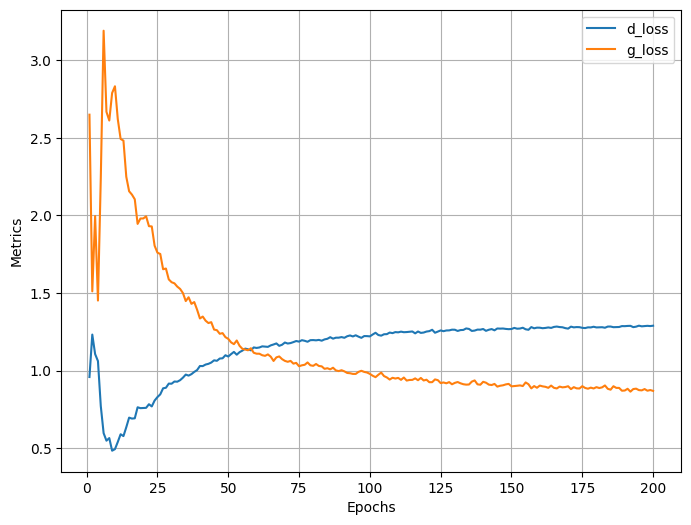

In [12]:
for epoch in range(num_epochs):
    N = len(data_loader)
    for i, (images, _) in enumerate(data_loader):
        real_data = images.view(len(images), -1).to(device)
        fake_data = generator(noise(len(real_data))).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(noise(len(real_data))).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss', 'g_loss'])

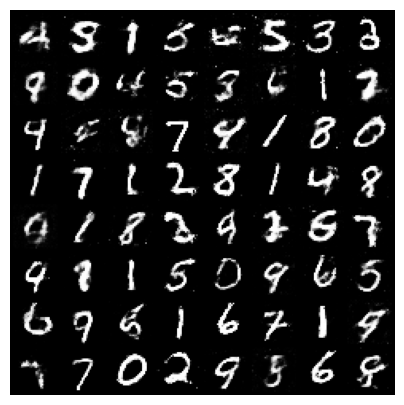

In [13]:
z = torch.randn(64, 100).to(device)
sample_images = generator(z).data.cpu().view(64, 1, 28, 28)
grid = make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=5)